# 00 — Setup + środowiska (GridWorld / FrozenLake)

Ten notebook ma jeden cel: **żeby wszystko odpaliło się „od strzała”** i żeby studenci zobaczyli,
że *to samo API* może obsłużyć GridWorld i FrozenLake.

**W bloku 1** będziemy pracować na środowiskach dyskretnych (tablice V/Q).  
**W bloku 2** przejdziemy do ciągłych obserwacji/akcji (MuJoCo), ale tu robimy most.

> Tip dydaktyczny: zacznij od GridWorld (deterministyczny) → potem FrozenLake (slippery) i różnica robi wrażenie.


In [3]:
import os, sys
# dodaj katalog główny repo do ścieżki importów
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

import numpy as np
import matplotlib.pyplot as plt

In [4]:
from envs.wrappers import make_gridworld, get_spec
from envs.frozenlake import FROZENLAKE_MAPS, build_frozenlake_P, find_start_state, PModelEnv
from algorithms.utils import plot_value_heatmap

## Wybór środowiska

Zmieniaj tylko `ENV_KIND`.  
- `gridworld` daje w pełni przewidywalny debug-friendly świat,  
- `frozenlake` pozwala pokazać probabilistykę i sens DP vs sample-based.


In [5]:
ENV_KIND = "frozenlake"   # "gridworld" albo "frozenlake"
SLIPPERY = True          # tylko dla FrozenLake

if ENV_KIND == "gridworld":
    env = make_gridworld(height=4, width=4,
                         start=(0,0), goal=(3,3),
                         holes=((1,1),(2,3)),
                         step_cost=0.0, seed=0)
elif ENV_KIND == "frozenlake":
    # FrozenLake budujemy z JAWNEGO modelu P[s][a], jak w notebookach Ch04/Ch05.
    # TODO: zmień mapę na "8x8" albo zdefiniuj własną listę stringów.
    desc = FROZENLAKE_MAPS["4x4"]

    # TODO: ustaw is_slippery=False i porównaj z True.
    P, nS, nA, nrow, ncol, desc_arr = build_frozenlake_P(desc, is_slippery=SLIPPERY)

    # TODO: znajdź indeks stanu startowego (S) i ustaw start_state 
    # przy pomocy find_start_state desc_arr
    # Poszukaj w pliku w envs 
    

    env = PModelEnv(P, start_state=s0, seed=0, desc=desc_arr)
    # atrybuty pomocnicze do wizualizacji/specyfikacji
    env.nrow, env.ncol, env.desc = nrow, ncol, desc_arr
else:
    raise ValueError("Nieznane ENV_KIND")

spec = get_spec(env, gamma=0.99)
spec

NameError: name 's0' is not defined

In [53]:
# Podgląd mapy i stanów terminalnych (FrozenLake)
if spec.desc is not None:
    print("FrozenLake map (S=start, F=frozen, H=hole, G=goal):")
    print("\n".join("".join(row) for row in spec.desc))
    print("\nTerminal states:", sorted(spec.terminals)[:10], "..." if len(spec.terminals)>10 else "")
    print("Akcje: 0=LEFT, 1=DOWN, 2=RIGHT, 3=UP")

FrozenLake map (S=start, F=frozen, H=hole, G=goal):
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Terminal states: [19, 29, 35, 41, 42, 46, 49, 52, 54, 59] ...
Akcje: 0=LEFT, 1=DOWN, 2=RIGHT, 3=UP


## Render / sanity-check

W GridWorld render pokazuje `A` (agent), `G` (goal), `H` (hole).  
FrozenLake nie ma fajnego rendera ANSI w każdym backendzie — ale mamy `desc` i indeksy stanów.


In [54]:
# GridWorld: prosta wizualizacja ANSI
if hasattr(env, "render"):
    print(env.render())

# Krótki rollout losową polityką (żeby sprawdzić API)
rng = np.random.default_rng(0)
def random_policy(s): 
    return int(rng.integers(0, spec.nA))

s, _ = env.reset()
for t in range(10):
    a = random_policy(s)
    sp, r, terminated, truncated, _ = env.step(a)
    print(f"t={t:02d} s={s} a={a} -> s'={sp} r={r} done={terminated or truncated}")
    s = sp
    if terminated or truncated:
        break

t=00 s=0 a=3 -> s'=0 r=0.0 done=False
t=01 s=0 a=2 -> s'=8 r=0.0 done=False
t=02 s=8 a=2 -> s'=16 r=0.0 done=False
t=03 s=16 a=1 -> s'=16 r=0.0 done=False
t=04 s=16 a=1 -> s'=17 r=0.0 done=False
t=05 s=17 a=0 -> s'=25 r=0.0 done=False
t=06 s=25 a=0 -> s'=24 r=0.0 done=False
t=07 s=24 a=0 -> s'=32 r=0.0 done=False
t=08 s=32 a=0 -> s'=32 r=0.0 done=False
t=09 s=32 a=3 -> s'=32 r=0.0 done=False


## Mapa wartości: jak będziemy ją oglądać

Wszystkie notebooki będą kończyć się podobnym wykresem: heatmapą \(V(s)\) lub \(\max_a Q(s,a)\).
Warto zwrócić uwagę, mamy tę samą rzecz zrobioną wg 3 różnych metod (DP/MC/TD).

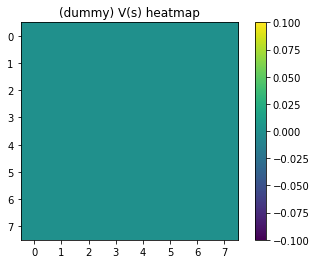

In [55]:
V_dummy = np.zeros(spec.nS)
plot_value_heatmap(V_dummy, spec.shape, title="(dummy) V(s) heatmap")

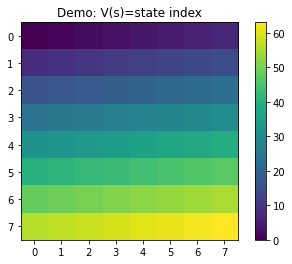

In [56]:
V_demo = np.arange(spec.nS, dtype=float)
plot_value_heatmap(V_demo, spec.shape, title="Demo: V(s)=state index")


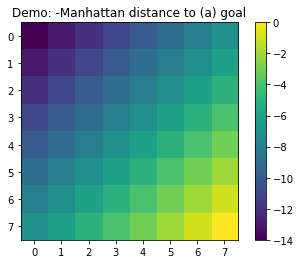

In [57]:

H, W = spec.shape
goal = max(spec.terminals)  # w gridworld często goal ma największy indeks; dla frozenlake lepiej znaleźć po 'G'
gr, gc = divmod(goal, W)

V_demo = np.zeros(spec.nS)
for s in range(spec.nS):
    r, c = divmod(s, W)
    #TODO policzyć Manhattan distance z definicji
    
    

plot_value_heatmap(V_demo, spec.shape, title="Demo: -Manhattan distance to (a) goal")


# Podglądanie P[s][a]

## Co oznacza `P[s][a]` w FrozenLake?

`P[s][a]` to **model przejść** (model środowiska) dla MDP.  
Dla danego **stanu** `s` i **akcji** `a` zwraca listę możliwych „wyników kroku” w postaci krotek:

$
P[s][a] = \{(p_i,\ s'_i,\ r_i,\ done_i)\}_{i=1}^k
$

gdzie:
- `p_i` – prawdopodobieństwo, że zajdzie dany wynik,
- `s'_i` – następny stan (indeks pola na planszy),
- `r_i` – nagroda za ten krok,
- `done_i` – czy epizod się kończy (np. wpadnięcie do `H` albo dojście do `G`).

Ważne: **prawdopodobieństwa sumują się do 1**:
$
\sum_i p_i = 1
$

---

## Jak czytać przykładowy wynik?

Przykład (dla `SLIPPERY=True`):

State s=0, action a=2 -> 3 outcome(s):

p=0.333 s'= 8 r=0.0 done=False

p=0.333 s'= 1 r=0.0 done=False

p=0.333 s'= 0 r=0.0 done=False


To znaczy:

- jesteśmy w stanie `s = 0` (zwykle lewy górny róg planszy),
- wybieramy akcję `a = 2`, czyli `RIGHT` (konwencja: `0=LEFT, 1=DOWN, 2=RIGHT, 3=UP`),
- ponieważ jest ślisko (`SLIPPERY=True`), akcja może „zjechać” w bok,
- dlatego mamy **3 możliwe następstwa**, każde z prawdopodobieństwem `1/3`.

Interpretacja tych trzech wierszy:
- z prawd. `1/3` trafiamy do `s'=1` (ruch w prawo),
- z prawd. `1/3` trafiamy do `s'=8` (ruch w dół na mapie 8×8, bo `(1,0)` ma indeks `1*8+0=8`),
- z prawd. `1/3` zostajemy w `s'=0` (np. „wypadł” ruch do góry, ale z brzegu nie da się wyjść poza planszę).

Nagroda `r=0.0` i `done=False` oznaczają: nie zakończyliśmy epizodu (nie weszliśmy na `H` ani `G`).

---

## Jak „poruszać się” po `P[s][a]` na dwóch przykładach?

Pomyśl o tym tak: **`P[s][a]` mówi: “jeśli zrobisz akcję `a` w stanie `s`, to świat wylosuje jeden z outcomes zgodnie z `p`.”**  
W DP (model-based) często robimy sumę po wszystkich outcomes. W MC/TD (model-free) zobaczymy tylko jedno wylosowane outcome.

### Przykład 1: `s = 0`, `a = RIGHT (2)`
1. Odczytujesz listę outcomes: `P[0][2]`.
2. Masz np. trzy możliwości: `(p=1/3, s'=1)`, `(p=1/3, s'=8)`, `(p=1/3, s'=0)`.
3. Środowisko (albo `PModelEnv.step`) losuje jedną z nich.

W DP „przejście” jest myślowe: uwzględniasz wszystkie trzy możliwości naraz przez sumę ważoną prawdopodobieństwami.

### Przykład 2 (kontynuacja): `s = 8` (czyli pole `(1,0)` na mapie 8×8), `a = RIGHT (2)`

Pamiętajmy kodowanie stanów na mapie 8×8:  
$s = r\cdot 8 + c$.  
Dla `s=8` mamy $(r,c)=(1,0)$.

---

##### Wariant A: `SLIPPERY = False` (deterministycznie)

Akcja `RIGHT` z $(1,0)$ prowadzi do $(1,1)$, czyli:
$s' = 1\cdot 8 + 1 = 9$.

Wtedy model ma tylko jeden outcome:

- $p=1.0$, $s'=9$, $r=0.0$, `done=False`

Czyli:
$P[8][2] = \{(1.0,\ 9,\ 0.0,\ \text{False})\}$.

---

##### Wariant B: `SLIPPERY = True` (jak poprzednio: 3 możliwości po $1/3$)

W FrozenLake ze ślizgiem, gdy wybierasz `RIGHT`, środowisko losuje faktyczną akcję z trzech:
- `DOWN` (1), `RIGHT` (2), `UP` (3) — każda z prawdopodobieństwem $1/3$.

Startujemy z $(1,0)$:

1) Faktycznie wypadnie `RIGHT`: $(1,0)\to(1,1)$, więc $s' = 9$  
2) Faktycznie wypadnie `DOWN`:  $(1,0)\to(2,0)$, więc $s' = 16$  
3) Faktycznie wypadnie `UP`:    $(1,0)\to(0,0)$, więc $s' = 0$

Dlatego typowo dostaniesz trzy outcomes:

- $p=\tfrac{1}{3}$, $s'=9$,  $r=0.0$, `done=False`
- $p=\tfrac{1}{3}$, $s'=16$, $r=0.0$, `done=False`
- $p=\tfrac{1}{3}$, $s'=0$,  $r=0.0$, `done=False`

czyli (schematycznie):
$P[8][2] = \{(\tfrac{1}{3},9,0,\text{F}),\ (\tfrac{1}{3},16,0,\text{F}),\ (\tfrac{1}{3},0,0,\text{F})\}$.

---

**Uwaga o terminalach:** to, czy $s'=9$ / $16$ / $0$ jest terminalem (`H`/`G`), zależy od mapy.  
Jeśli któryś z tych stanów jest terminalny, to w odpowiadającym outcome zobaczysz `done=True` (oraz nagrodę zgodną z regułą środowiska).


---

### Mini-podsumowanie
- `P[s][a]` to **jawny model środowiska**: wszystkie możliwe następstwa kroku.
- `step()` to **jedna próbka** z `P[s][a]`.
- DP wykorzystuje `P[s][a]` bez próbkowania (suma po outcomes),
- MC/TD uczą się z trajektorii, czyli z próbek.


In [86]:
# ============================================================
# A)  Model przejść P[s][a]: co dokładnie "wie" DP?
# ============================================================
# TODO: Zmień SLIPPERY=True/False i zobacz jak zmienia się liczba outcomes.
# TODO: Zmień mapę (np. "4x4" vs "8x8") i porównaj P[s][a].

if ENV_KIND != "frozenlake":
    print("Ta komórka dotyczy FrozenLake. Ustaw ENV_KIND='frozenlake' i uruchom ponownie komórkę tworzącą env/spec.")
else:
    # Upewnijmy się, że mamy s0 (start state). Jeśli nie, spróbujmy go wyznaczyć.
    try:
        _ = s0
    except NameError:
        from envs.frozenlake import find_start_state
        s0 = find_start_state(desc_arr)

    s_test = int(s0)
    a_test = 2  # RIGHT

    outcomes = P[s_test][a_test]   # lista (p, s', r, done)
    print(f"State s={s_test}, action a={a_test} -> {len(outcomes)} outcome(s):")
    for (p, s_next, r, done) in outcomes:
        print(f"  p={p:.3f}  s'={s_next:>3}  r={r:>5}  done={done}")

    sum_p = sum(p for (p, *_rest) in outcomes)
    print(f"\nSum of probabilities = {sum_p:.12f}")

    # autokontrola poprawności modelu
    assert abs(sum_p - 1.0) < 1e-12, "Prawdopodobieństwa w P[s][a] nie sumują się do 1!"
    print("OK: rozkład w P[s][a] jest poprawny (sumuje się do 1).")


State s=0, action a=2 -> 3 outcome(s):
  p=0.333  s'=  8  r=  0.0  done=False
  p=0.333  s'=  1  r=  0.0  done=False
  p=0.333  s'=  0  r=  0.0  done=False

Sum of probabilities = 1.000000000000
OK: rozkład w P[s][a] jest poprawny (sumuje się do 1).


In [2]:
# ============================================================
# B) "Model vs próbki": DP sumuje po outcomes, MC/TD widzą próbki z step()
# ============================================================
# TODO: Ustaw SLIPPERY=True i zwiększ N do 2000–5000, zobacz zbieżność histogramu do P[s][a].
# TODO: Ustaw SLIPPERY=False i zobacz, że zawsze dostajesz to samo s' (deterministycznie).

from collections import Counter

if ENV_KIND != "frozenlake":
    print("Ta komórka dotyczy FrozenLake. Ustaw ENV_KIND='frozenlake' i uruchom ponownie komórkę tworzącą env/spec.")
else:
    # SOLUTION: upewniamy się, że mamy s0
    try:
        _ = s0
    except NameError:
        from envs.frozenlake import find_start_state
        s0 = find_start_state(desc_arr)

    # TODO: wybieramy stan i akcję testową
    s_test = # stan s0
    a_test =   # RIGHT

    # TODO: zmieniaj liczbę prób
    N = 10000

    # --- teoretyczny rozkład z modelu P ---
    theo = {s_next: p for (p, s_next, r, done) in P[s_test][a_test]}

    # --- empiryczny rozkład z próbkowania env.step ---
    counts = Counter()
    r_counts = Counter()
    done_counts = Counter()

    for _ in range(N):
        env.reset()

        # Ustawiamy środowisko w stanie s_test (dla czystego porównania rozkładów z P[s][a]).
        # Jeśli Twoje env używa innej nazwy niż env.s, tu trzeba zmienić 1 linijkę.
        if hasattr(env, "s"):
            env.s = int(s_test)
        else:
            raise AttributeError("Env nie ma atrybutu 's'. Sprawdź w PModelEnv jak nazywa się stan wewnętrzny i podmień tę linię.")

        s_next, r, terminated, truncated, info = env.step(a_test)
        done = bool(terminated or truncated)

        counts[int(s_next)] += 1
        r_counts[float(r)] += 1
        done_counts[done] += 1

    emp = {s_next: counts[s_next] / N for s_next in sorted(counts.keys())}

    print(f"Empirical transitions from s={s_test} with a={a_test} over N={N} samples:")
    for s_next in sorted(set(list(theo.keys()) + list(emp.keys()))):
        p_theo = theo.get(s_next, 0.0)
        p_emp  = emp.get(s_next, 0.0)
        print(f"  s'={s_next:>3}:  P_theory={p_theo:>6.3f}   P_emp={p_emp:>6.3f}")

    print("\nRewards observed (empirical counts):", dict(r_counts))
    print("Done observed (empirical counts):", dict(done_counts))

    print("\nWniosek dydaktyczny:")
    print("• env.step() daje pojedynczą próbkę z rozkładu P[s][a].")
    print("• DP używa P[s][a] bez próbkowania; MC/TD muszą estymować z trajektorii.")


ModuleNotFoundError: No module named 'envs'

## Zadanie: zbieżność rozkładu empirycznego do $P[s][a]$

Masz gotowy kod, który:
1) bierze rozkład teoretyczny z modelu $P[s][a]$,
2) próbuje go odtworzyć empirycznie przez wielokrotne wywołania `step()`.

Twoim zadaniem **nie jest zmieniać logiki próbkowania**, tylko:
- dodać **tabelę** z wynikami dla różnych $N$ **albo**
- dodać **wykres(y)** pokazujące zbieżność $\hat p_N(s') \to p(s')$.

Wskazówka: typowa skala błędu maleje jak $1/\sqrt{N}$.


In [75]:
# ============================================================
# GIVEN: dane do zadania (nie zmieniać logiki próbkowania)
# ============================================================

from collections import Counter
from envs.frozenlake import PModelEnv

assert ENV_KIND == "frozenlake", "Ustaw ENV_KIND='frozenlake'"

s_test = int(s0)
a_test = 2  # RIGHT
Ns = [10, 30, 100, 300, 1000, 3000, 10000]
base_seed = 123

# teoria
theo_list = P[s_test][a_test]
theo = {int(s_next): float(p) for (p, s_next, r, done) in theo_list}
support = sorted(theo.keys())

def estimate_empirical_probs(N: int, seed: int):
    tmp_env = PModelEnv(P, start_state=s_test, seed=seed, desc=desc_arr)
    counts = Counter()
    for _ in range(N):
        tmp_env.reset()
        s_next, r, terminated, truncated, info = tmp_env.step(a_test)
        counts[int(s_next)] += 1
    emp = {s_next: counts[s_next] / N for s_next in counts.keys()}
    return emp

# dane w formie listy rekordów
rows = []
for i, N in enumerate(Ns):
    emp = estimate_empirical_probs(N, seed=base_seed + i)
    emp_vec = [emp.get(s_next, 0.0) for s_next in support]
    theo_vec = [theo[s_next] for s_next in support]
    diffs = [abs(e - t) for e, t in zip(emp_vec, theo_vec)]
    rows.append({
        "N": N,
        "emp": emp,
        "emp_vec": emp_vec,
        "theo_vec": theo_vec,
        "max_err": max(diffs) if diffs else 0.0,
        "l1_err": sum(diffs),
    })

print("OK: dane policzone. Teraz dodaj tabelę albo wykres (zadanie).")
print("Support states:", support)


OK: dane policzone. Teraz dodaj tabelę albo wykres (zadanie).
Support states: [0, 1, 8]


In [77]:
# ============================================================
# TODO: Zrób tabelę wyników dla różnych N
# - Wypisz p_emp(s') dla każdego s' w support, emp_vec
# - Dodaj kolumny: max_err i l1_err
# ============================================================

# SOLUTION: poniżej jest przykład tabeli tekstowej
header = "N".rjust(7) + " | " + "  ".join([f"s'={s_next}".rjust(10) for s_next in support]) + " | max|Δ|   L1"
print(header)
print("-" * len(header))
# TODO Stwórz tabelkę poniżej
#for row in rows:
#    N = row["N"]
#    emp_vec = #
#    max_err = #
#    l1_err = #
#    line = str(N).rjust(7) + " | " + "  ".join(#)"
#    print(line)


      N |       s'=0        s'=1        s'=8 | max|Δ|   L1
----------------------------------------------------------
     10 |     0.5000      0.0000      0.5000 |  0.3333   0.6667
     30 |     0.3333      0.3333      0.3333 |  0.0000   0.0000
    100 |     0.3700      0.2600      0.3700 |  0.0733   0.1467
    300 |     0.3600      0.3100      0.3300 |  0.0267   0.0533
   1000 |     0.3140      0.3440      0.3420 |  0.0193   0.0387
   3000 |     0.3380      0.3297      0.3323 |  0.0047   0.0093
  10000 |     0.3356      0.3292      0.3352 |  0.0041   0.0083


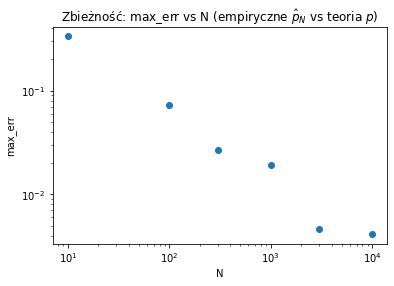

In [85]:
# ============================================================
# TODO: Narysuj wykres zbieżności błędu
# - Oś X: N (najlepiej w skali log)
# - Oś Y: max_err (albo l1_err)
# - Opcjonalnie: dorysuj linię ~ 1/sqrt(N) jako punkt odniesienia
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

Ns_plot = # np.array([ #### for row in rows], dtype=float)
max_err_plot = # np.array([ ### for row in rows], dtype=float)

plt.figure()
#plt.scatter(Ns_plot, max_err_plot, marker="o")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("N")
plt.ylabel("max_err")
plt.title("Zbieżność: max_err vs N (empiryczne $\\hat p_N$ vs teoria $p$)")

plt.show()
